Install Dependencies

In [389]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [390]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.ensemble import RandomForestClassifier

import numpy as np

Load Dataset

In [391]:
# Load the processed dataset
df = pd.read_csv("data/processed_dataset.csv", index_col=0)
print("Dataset loaded successfully from 'data/processed_dataset.csv'")

df.head()

Dataset loaded successfully from 'data/processed_dataset.csv'


,blueTeamControlWardsPlaced,blueTeamWardsPlaced,blueTeamTotalKills,blueTeamDragonKills,blueTeamHeraldKills,blueTeamTowersDestroyed,blueTeamInhibitorsDestroyed,blueTeamTurretPlatesDestroyed,blueTeamFirstBlood,blueTeamMinionsKilled,...,diffJungleMinions,diffTotalGold,diffTotalKills,diffXp,diffTotalDamageToChamps,diffDragonKills,diffHeraldKills,diffTowersDestroyed,diffInhibitorsDestroyed,diffTurretPlatesDestroyed
matchId,,,,,,,,,,,,,,,,,,,,,
EUW1_6882489515',2,23,4,2,0,0,0,7,0,388,...,12,-5714,-12,-2815,-5397,2,0,-2,0,6
EUW1_6882416210',2,46,12,1,0,1,0,10,0,348,...,22,-1118,-5,210,-768,1,0,0,0,6
EUW1_6881092720',2,19,13,0,0,0,0,11,0,331,...,12,-2384,-5,37,-4945,-1,0,-2,0,8
EUW1_6879405717',3,28,8,0,1,1,0,9,1,355,...,-3,2176,-2,-603,3109,-1,1,1,0,4
EUW1_6879389461',3,30,11,1,1,1,0,7,0,370,...,4,1720,4,1591,7431,0,1,0,0,2


In [392]:
"""

# 6 Most significant features for both teams and difference (6x3=18 features)
# Results of around 0.4875 (0.0015 difference wrt all features)
features_to_keep = [
       'diffTotalGold', 'diffXp', 'diffTotalKills', 'blueTeamTotalGold',
       'diffTotalDamageToChamps', 'redTeamTotalGold', 'blueTeamXp',
       'redTeamXp', 'blueTeamTotalKills', 'diffMinionsKilled',
       'diffDragonKills', 'redTeamTotalKills', 'blueTeamDragonKills',
       'redTeamTotalDamageToChamps', 'blueTeamTotalDamageToChamps',
       'redTeamMinionsKilled', 'blueTeamMinionsKilled', 'redTeamDragonKills',
       'blueWin'
       ]


# 3 Most significant features for both teams and difference (3x3=9 features)
# Results of around 0.4965 (0.0105 difference wrt all features)
features_to_keep = [
       'diffTotalGold', 'diffXp', 'diffTotalKills',
       'blueTeamTotalGold', 'redTeamTotalGold', 
       'redTeamXp', 'blueTeamXp',
       'blueTeamTotalKills','redTeamTotalKills',
       'blueWin'
       ]


# Ensure that only existing columns are selected
selected_columns = [col for col in features_to_keep if col in df.columns]
df = df[selected_columns]

"""


"\n\n# 6 Most significant features for both teams and difference (6x3=18 features)\n# Results of around 0.4875 (0.0015 difference wrt all features)\nfeatures_to_keep = [\n       'diffTotalGold', 'diffXp', 'diffTotalKills', 'blueTeamTotalGold',\n       'diffTotalDamageToChamps', 'redTeamTotalGold', 'blueTeamXp',\n       'redTeamXp', 'blueTeamTotalKills', 'diffMinionsKilled',\n       'diffDragonKills', 'redTeamTotalKills', 'blueTeamDragonKills',\n       'redTeamTotalDamageToChamps', 'blueTeamTotalDamageToChamps',\n       'redTeamMinionsKilled', 'blueTeamMinionsKilled', 'redTeamDragonKills',\n       'blueWin'\n       ]\n\n\n# 3 Most significant features for both teams and difference (3x3=9 features)\n# Results of around 0.4965 (0.0105 difference wrt all features)\nfeatures_to_keep = [\n       'diffTotalGold', 'diffXp', 'diffTotalKills',\n       'blueTeamTotalGold', 'redTeamTotalGold', \n       'redTeamXp', 'blueTeamXp',\n       'blueTeamTotalKills','redTeamTotalKills',\n       'blueWin'\n

Train-test Split

In [393]:
X = df.drop(columns=["blueWin"])
y = df["blueWin"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X shape: (24218, 38)
y shape: (24218,)


Scaling

In [394]:
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Feature Selection

In [395]:
def find_bestKfeatures(model):
  print("Performing feature selection...")
  # Select best k features
  k = -1
  max_score = 0
  for i in range(1, 38, 3):
    selector = SelectKBest(k=i)
    pipeline = Pipeline([('selector', selector), ('model', model)])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print("K: {}, score: {}".format(i, score))
    if score > max_score:
      k = i
      max_score = score
      selected_features_indices = selector.get_support(indices=True)
  print("Best K number: {}, score: {}".format(k, max_score))
  print("Selected features: ", list(X.columns[selected_features_indices]))
  print()
  # return feature index list
  return list(selected_features_indices)

In [396]:
def rec_feature_elim_cv(model):
    print("Performing recursive feature elimination with cross-validation...")
    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    rfecv = RFECV(estimator=model, step=3, cv=cv, scoring='neg_log_loss')
    rfecv.fit(X_train, y_train)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Selected features: ", list(X.columns[rfecv.support_]))
    print()
    
    selected_indices = [i for i, selected in enumerate(rfecv.support_) if selected]

    return selected_indices

In [397]:
def apply_feature_selection(X, selected_features_indices):
  return X.iloc[:, selected_features_indices]

Hyper-Parameter Tuning

In [398]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

def train_model_with_random_search(model, param_grid, X_train, y_train):
    print("Starting training...")

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10,
                                       scoring='neg_log_loss', n_jobs=-1, cv=cv)

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    print("Training completed")
    print()

    # Get best estimator
    best_model = random_search.best_estimator_
    # Get best training score
    best_score = random_search.best_score_
    print('Best Training Score: ', best_score)
    # Get best param
    best_param = random_search.best_params_
    print('Best Parameters: ', best_param)
    print()

    # Return model
    return best_model, best_param

Model Evaluation

In [399]:
def compute_log_loss(model, X_test, y_test):
    print("Model Evaluation: ")

    # Predict on test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute Log Loss
    loss = log_loss(y_test, y_pred_prob)
    print('Log Loss: ', loss)
    print()

    return loss



def compute_other_metrics(model, X_test, y_test):

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    # ROC AUC plot
    fper, tper, _ = roc_curve(y_test, y_pred_prob)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

    plt.show()

    return accuracy, f1, roc_auc

Get Feature Importance

In [400]:
def display_feature_importance(rf, feature_names):

    # Assuming rf is your trained RandomForestClassifier and X_train is your training data
    importances = rf.feature_importances_

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    print(feature_names[indices])

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.tight_layout()
    plt.show()

Random Forest Classifier

Starting training...
Training completed

Best Training Score:  -0.4875887501898018
Best Parameters:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}

Model Evaluation: 
Log Loss:  0.4865506920325468

Accuracy:  0.7539223781998349
F1 Score:  0.7539059273740065
AUC(ROC):  0.8422603289712525

Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2463
           1       0.75      0.75      0.75      2381

    accuracy                           0.75      4844
   macro avg       0.75      0.75      0.75      4844
weighted avg       0.75      0.75      0.75      4844



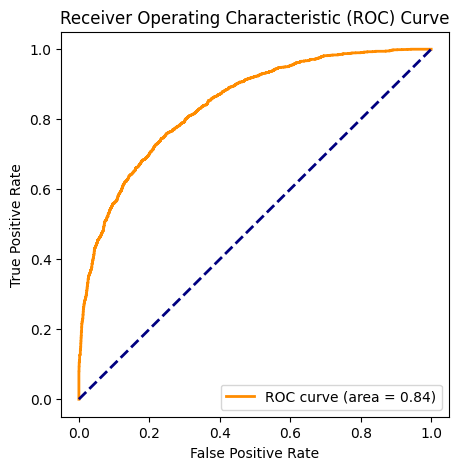

Feature ranking:
Index(['diffTotalGold', 'diffXp', 'diffTotalKills', 'blueTeamTotalGold',
       'diffTotalDamageToChamps', 'redTeamTotalGold', 'redTeamXp',
       'blueTeamXp', 'blueTeamTotalKills', 'diffMinionsKilled',
       'diffDragonKills', 'redTeamTotalKills', 'blueTeamDragonKills',
       'redTeamTotalDamageToChamps', 'blueTeamTotalDamageToChamps',
       'redTeamMinionsKilled', 'blueTeamMinionsKilled',
       'diffTurretPlatesDestroyed', 'diffJungleMinions',
       'blueTeamJungleMinions', 'redTeamDragonKills', 'redTeamWardsPlaced',
       'redTeamJungleMinions', 'blueTeamWardsPlaced', 'diffTowersDestroyed',
       'redTeamTurretPlatesDestroyed', 'blueTeamTurretPlatesDestroyed',
       'redTeamControlWardsPlaced', 'blueTeamControlWardsPlaced',
       'blueTeamTowersDestroyed', 'redTeamTowersDestroyed',
       'blueTeamFirstBlood', 'diffHeraldKills', 'blueTeamHeraldKills',
       'redTeamHeraldKills', 'diffInhibitorsDestroyed',
       'redTeamInhibitorsDestroyed', 'blueTeamInhi

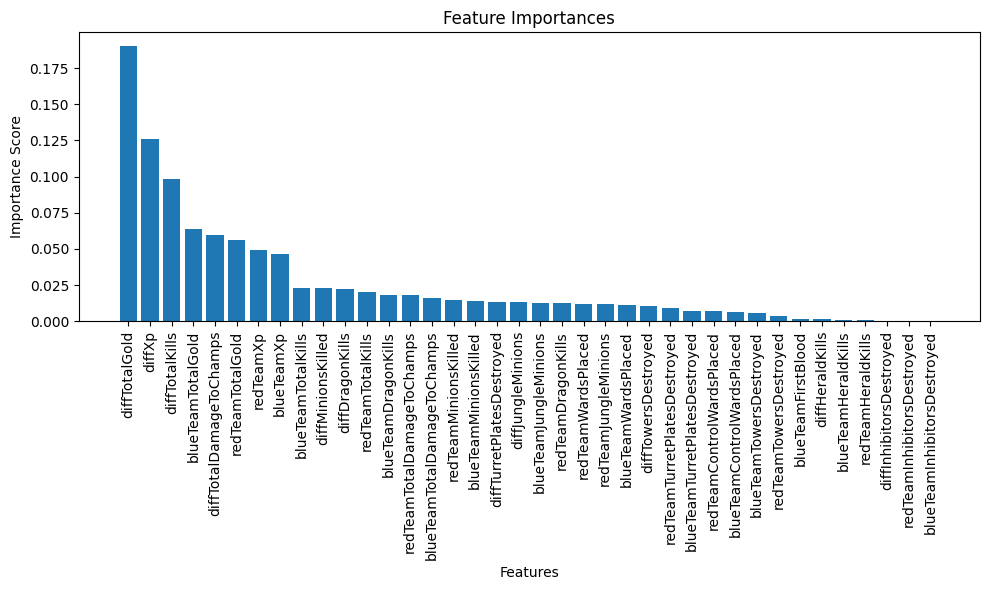

In [401]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'criterion': ['entropy'],
    'max_depth': [None, 3, 4, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestClassifier(n_estimators=300,
                               criterion='entropy',
                               max_depth=10,
                               min_samples_split=5,
                               min_samples_leaf=2,
                               n_jobs=-1,
                               random_state=0)

# Perform feature selection
#selected_features = find_bestKfeatures(model)
#selected_features = rec_feature_elim_cv(model)
X_train_rd, X_test_rd = X_train, X_test
#X_train_rd, X_test_rd = apply_feature_selection(X_train, selected_features), apply_feature_selection(X_test, selected_features)

# Train model with RandomizedSearchCV
trained_model, param_sample = train_model_with_random_search(model, param_grid, X_train_rd, y_train)

# Evaluate model
log_loss = compute_log_loss(trained_model, X_test_rd, y_test)
accuracy, f1, roc_auc = compute_other_metrics(trained_model, X_test_rd, y_test)

# Display feature importance
display_feature_importance(trained_model, X_train_rd.columns)